# Analysis of barcode sequencing test run after genome integration

© 2022 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In [2]:
using wgregseq, CairoMakie, CSV, DataFrames
wgregseq.plotting_style.default_makie!()

┌ Warning: SIMD capacity not detected by ScanByte, using scalar fallback
└ @ ScanByte /Users/tomroeschinger/.julia/packages/ScanByte/eOQJf/src/ScanByte.jl:11


## Import processed sequencing data

First we import the data for all 6 samples. Then, we plot the number of sequencing counts per barcode in ranked order.

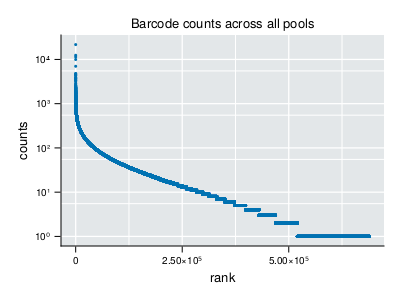

In [3]:
df = DataFrame()
for i in [1, 2, 3, 41, 42, 43]
    _df = CSV.read("../../../data/processed_barcodes/20220810_barcode_test/$(i)_collapsed.txt", DataFrame, ignorerepeated=true, delim=" ", header=["counts", "barcode"])
    insertcols!(_df, 3, :sample => i)
    append!(df, _df)
end
cdf = combine(groupby(df, :barcode), :counts => sum => :total_counts)
sort!(cdf, :total_counts, rev=true)
fig = Figure(resolution=(400, 300))
ax = Axis(fig[1, 1], yscale=log10)
scatter!(ax, 1:length(cdf.total_counts), cdf.total_counts, markersize=3)
ax.ylabel = "counts"
ax.xlabel = "rank"
ax.title = "Barcode counts across all pools"
fig

Next we compare the different samples. Therefore, we plot the number of counts of a barcode in one sample to the number of counts in another sample. This will show us if the samples are complementary, meaning if they contain the same barcodes or if they have unique ones.

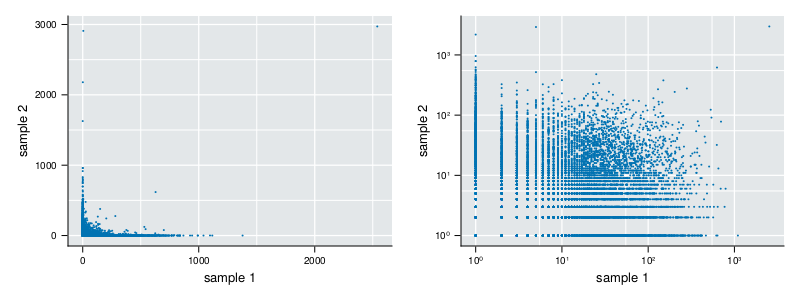

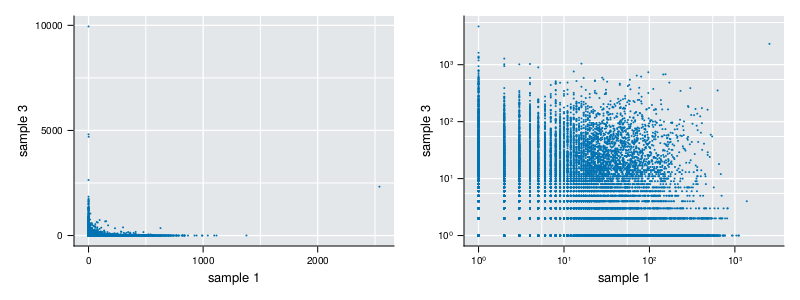

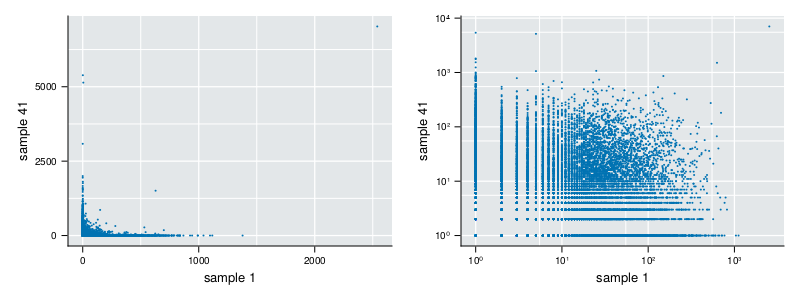

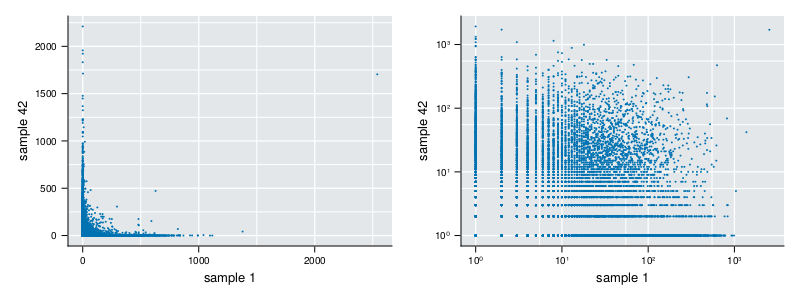

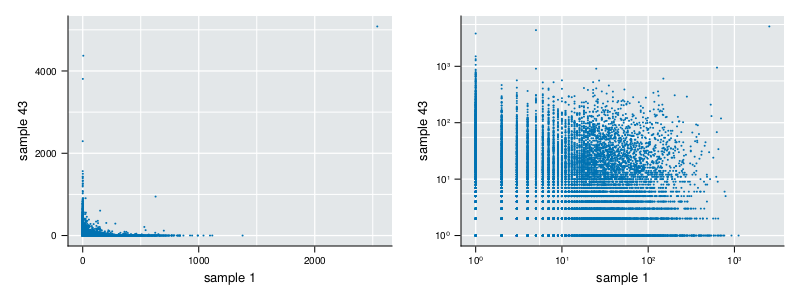

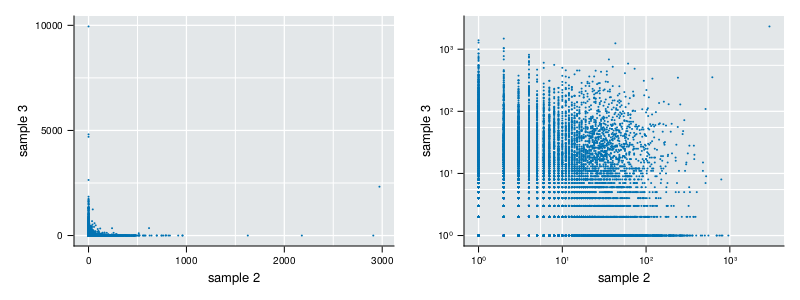

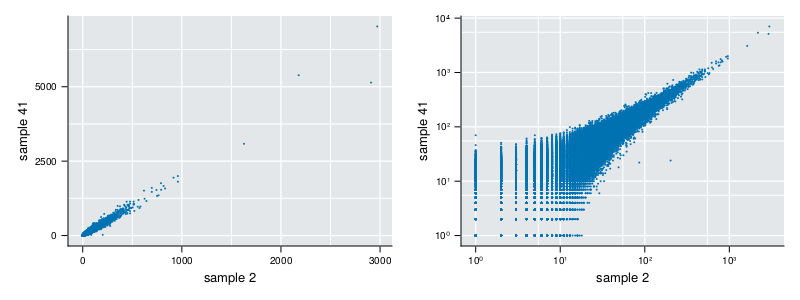

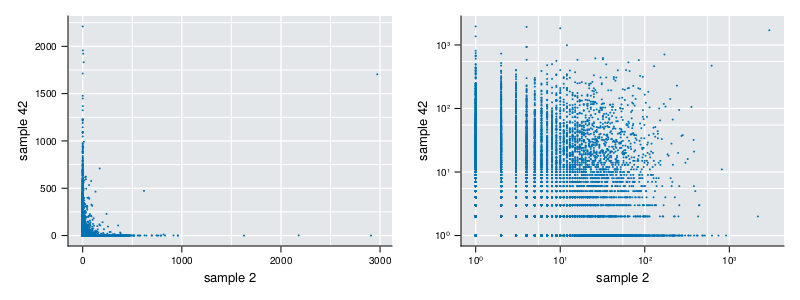

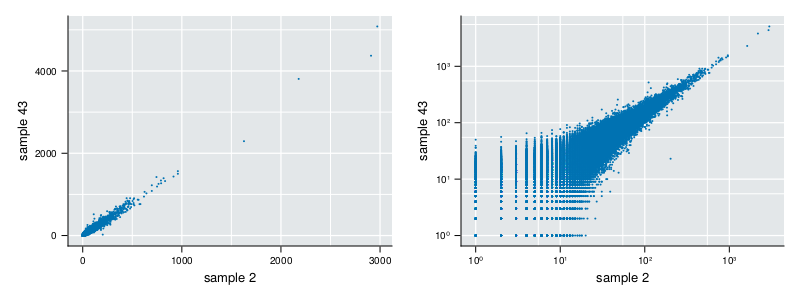

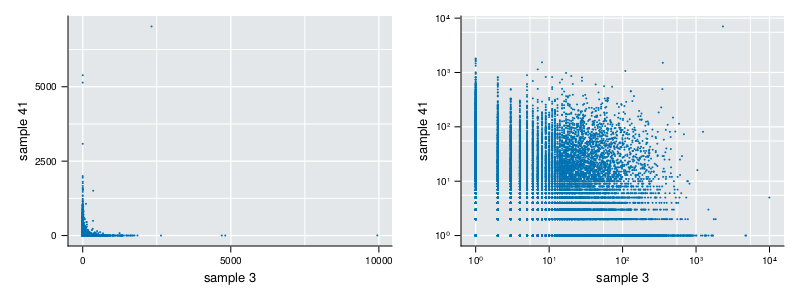

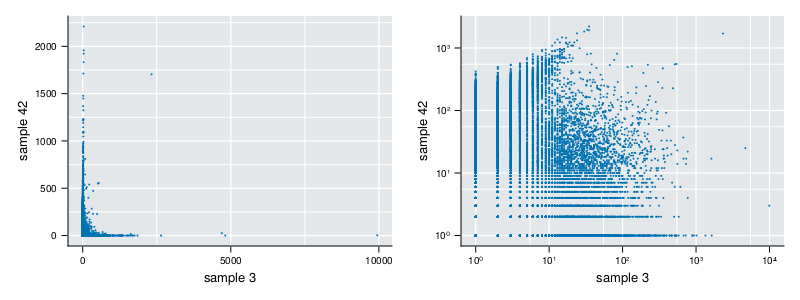

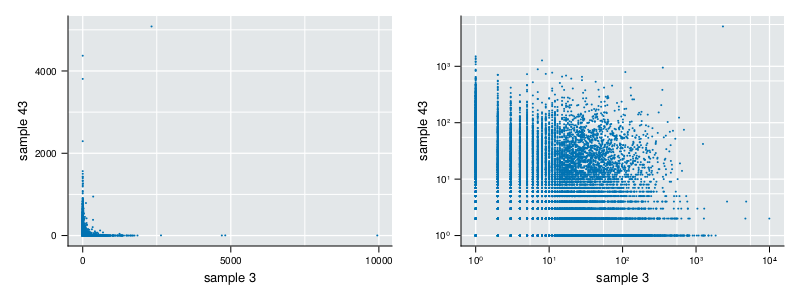

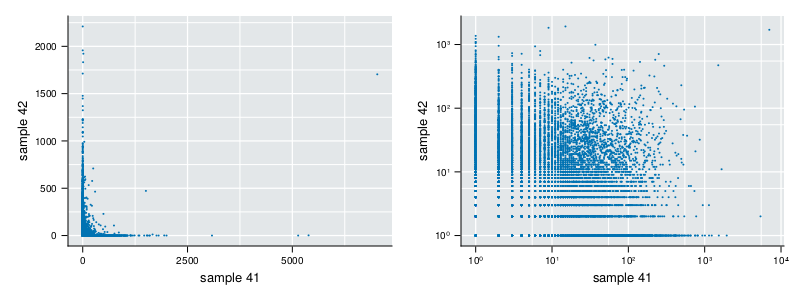

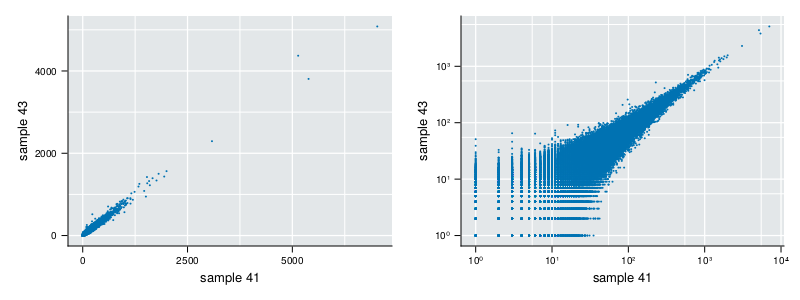

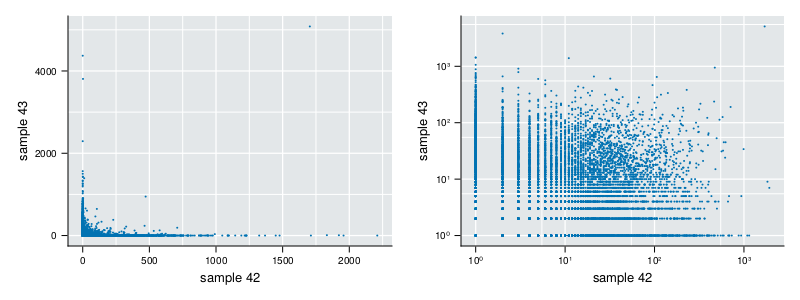

In [4]:
function compare_samples(df, i1, i2)
    fig = Figure(resolution=(800, 300))
    ax1 = Axis(fig[1, 1])
    ax2 = Axis(fig[1, 2], xscale=log10, yscale=log10)

    scatter!(ax1, df[!, Symbol(i1)], df[!, Symbol(i2)], markersize=2)
    ax1.xlabel = "sample $i1"
    ax1.ylabel = "sample $i2"

    _df = df[(df[!, Symbol(i1)] .> 0) .& (df[!, Symbol(i2)] .> 0), :]
    scatter!(ax2, _df[!, Symbol(i1)], _df[!, Symbol(i2)], markersize=2)
    ax2.xlabel = "sample $i1"
    ax2.ylabel = "sample $i2"
    return fig
end
df_unstacked = unstack(df, :sample, :counts, fill=0)
samples = df.sample |> unique |> sort
for i in 1:length(samples)
    for j in i+1:length(samples)
        display(compare_samples(df_unstacked, samples[i], samples[j]))
    end
end

In [5]:
df_mapping = CSV.read("../../../data/barcodes/20220514_mapping/mapped_barcodes.csv", DataFrame)

,promoter
,String
1,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG
2,GAGGACGACATACGCATTCATCTCTTGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAATGCCCTCACCATAAATGTGCAGTTTCATGATTTCCCTGTATTAGATGACTGGATGGATTGCCCTTATCACCCGATTAACTGCGTTTTTCACATACTTG
3,GATTACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTCGTCATGCGATAACGCACTCACCATAGATTTGTAGTCTAATGATTTCCCTGGATTTTATGACAGGATGGCTTTCCCTGCTCCCCCGACTAAGTTTGCTTTTCACATACTTG
4,GATAACGACTAACTCATTCATCTCATGGCTGCCGTACGAGACTTTTCCTGGGCAGAAGATAACCCACTCACCATAAATGAGCAGTTTAATGATTTCCCTGGATGTTGTGACTGTATGGATTACCCTGATCACCCGGTTAAATTTGTTATTCCCATACTTG
5,GATGACGATAAATTCATTCATCTGATGGCTGCCGCACGAGACTCTGAGTGGTCAGACGATAATGCACTCACCATAAATGTACAGCTAAATGTTTTCCCTCGATTTTATCACTGGATGGATTCCCCTGATCACCGGGTTCAGTTTGTTTTTCACATCCTTG
6,GATGACGACAAAATCGTTCACCTTATGCCTGCCGTAAGAGTCTGTGAGTGGTCAGACGATAACGGACTCACCTTAAATCTGCAGCTTAAGAATTTCCCTGGATTTTATGACTGGATGGATTAGCCTGATCACCCGGTTAAGTTTTATTTTCACATACTTG
7,GATGACGAGAAACTCACTATTCTCATGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAACGCACTCTCCAAAAATGTGAAGTTCAATGATTTCTCTGGATTTTATGACTGGATCGTTTACCCTTATCACCCCGTTATGTTTGGTTTTTACATACTTG
8,GATGACCACAGACTCAGTCATCTCATGGCTGCCGTACGAGCCTGTGCGTGGTCAGACGATAACGAACTCACCATAAATGTGCAGTTTAAAGAATTCCCTGGATACTATGACTTGCTGGATTTCCCTGATCACCCGGCTACGTTTGTTTTTCACATAATTG
9,GATGACGACAAACTCATTCATCTCATGGCTGCCTGCCGACACTGTGAGTGGTCAGACGATAACGGCCTCGCCATAAATATGCACTTTCATCATTTCCCTGGATTTTATGACTGGATGGCTTACCCTGATCACCCGATTAAGCTTGTTTTTCAGACACTTG


In [6]:
df_mapping |> names

4-element Vector{String}:
 "promoter"
 "barcode"
 "counts"
 "name"

In [7]:
df_join = innerjoin(df, df_mapping[!, ["barcode", "promoter", "name"]], on="barcode")

,counts,barcode,sample,promoter
,Int64,String31,Int64,String
1,5,TGGGTATATCCCCAAGGGAT,2,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG
2,2,TGGGTATATCCCCAAGGGAT,3,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG
3,16,TGGGTATATCCCCAAGGGAT,41,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG
4,12,TGGGTATATCCCCAAGGGAT,43,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG
5,10,GTCATTGGATCTTGAACTTA,2,GATTACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTCGTCATGCGATAACGCACTCACCATAGATTTGTAGTCTAATGATTTCCCTGGATTTTATGACAGGATGGCTTTCCCTGCTCCCCCGACTAAGTTTGCTTTTCACATACTTG
6,19,GTCATTGGATCTTGAACTTA,41,GATTACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTCGTCATGCGATAACGCACTCACCATAGATTTGTAGTCTAATGATTTCCCTGGATTTTATGACAGGATGGCTTTCCCTGCTCCCCCGACTAAGTTTGCTTTTCACATACTTG
7,16,GTCATTGGATCTTGAACTTA,43,GATTACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTCGTCATGCGATAACGCACTCACCATAGATTTGTAGTCTAATGATTTCCCTGGATTTTATGACAGGATGGCTTTCCCTGCTCCCCCGACTAAGTTTGCTTTTCACATACTTG
8,1,CACTCCGGCGGTAACTCCGC,2,GATAACGACTAACTCATTCATCTCATGGCTGCCGTACGAGACTTTTCCTGGGCAGAAGATAACCCACTCACCATAAATGAGCAGTTTAATGATTTCCCTGGATGTTGTGACTGTATGGATTACCCTGATCACCCGGTTAAATTTGTTATTCCCATACTTG
9,2,CACTCCGGCGGTAACTCCGC,3,GATAACGACTAACTCATTCATCTCATGGCTGCCGTACGAGACTTTTCCTGGGCAGAAGATAACCCACTCACCATAAATGAGCAGTTTAATGATTTCCCTGGATGTTGTGACTGTATGGATTACCCTGATCACCCGGTTAAATTTGTTATTCCCATACTTG


In [8]:
function plot_ident_prom_per_sample(df, sample; threshold=10)
    _df = df[df.sample .== sample, :]
    
    fig = Figure(resolution=(1400, 700))
    ax = Axis(fig[1, 1])

    df_thresh = _df[_df.counts .> 1, :]
    # function to count unique entries
    num_unique(x) = length(unique(x))
    df_thresh = combine(groupby(df_thresh, [:name, :promoter]), :barcode => length => :uniq_barcodes)
    df_thresh = df_thresh[df_thresh.uniq_barcodes .> threshold, :]
    # Count unique variants per promoter
    df_thresh = combine(groupby(df_thresh, :name), :promoter => num_unique)

    # Sort by number of variants
    sort!(df_thresh, :promoter_num_unique, rev=true)
    barplot!(
        ax, 
        1:nrow(df_thresh), 
        df_thresh.promoter_num_unique
    )
    ax.xticks = (1:nrow(df_thresh), df_thresh.name)
    ax.xticklabelrotation = pi/4
    ax.yticklabelsize = 12
    ax.title = "Unique variants per promoter with at least 10 barcodes for sample $sample"
    ax.titlesize=15
    return fig
end

    

plot_ident_prom_per_sample (generic function with 1 method)

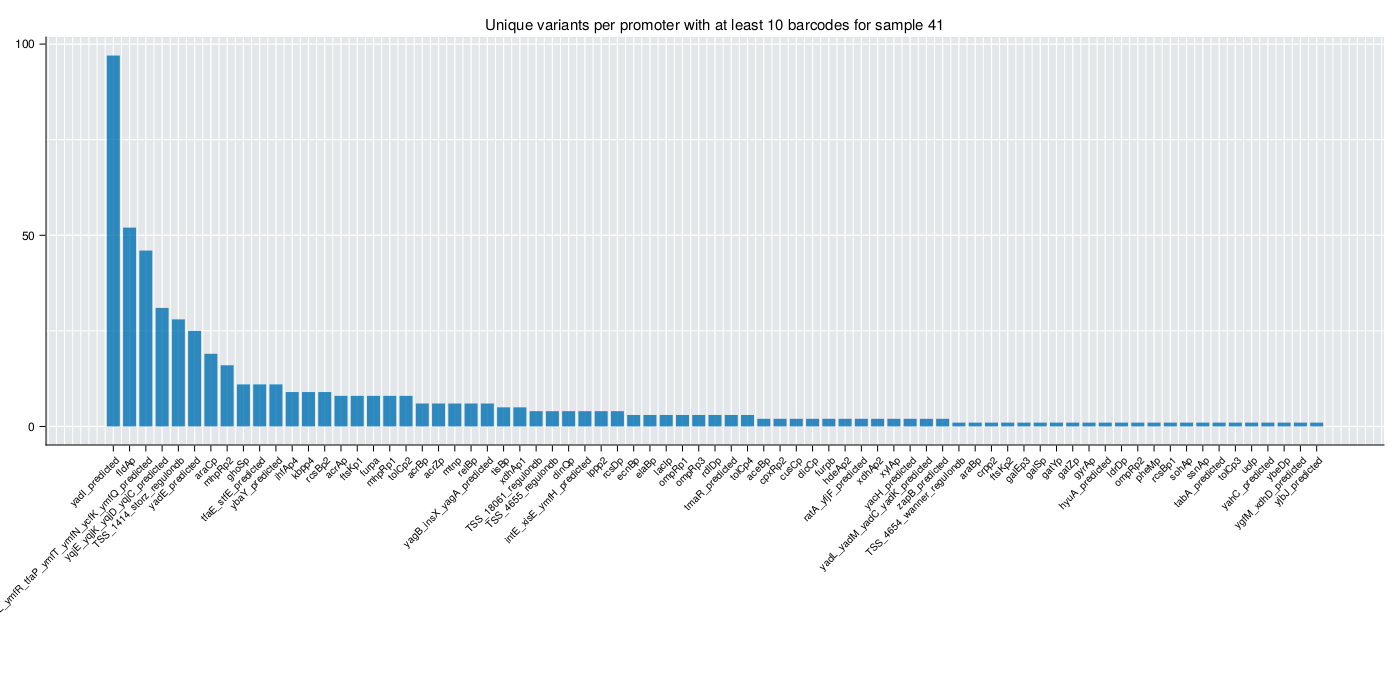

In [9]:
plot_ident_prom_per_sample(df_join, 41, threshold = 5)

In [10]:
function plot_ident_prom_all_samples(df; threshold=10)
    _df = combine(groupby(df, [:barcode, :promoter, :name]), :counts => sum => :tot_counts)
    fig = Figure(resolution=(1400, 700))
    ax = Axis(fig[1, 1])

    df_thresh = _df[_df.tot_counts .> 1, :]
    # function to count unique entries
    num_unique(x) = length(unique(x))
    df_thresh = combine(groupby(df_thresh, [:name, :promoter]), :barcode => length => :uniq_barcodes)
    df_thresh = df_thresh[df_thresh.uniq_barcodes .> threshold, :]
    # Count unique variants per promoter
    df_thresh = combine(groupby(df_thresh, :name), :promoter => num_unique)

    # Sort by number of variants
    sort!(df_thresh, :promoter_num_unique, rev=true)
    barplot!(
        ax, 
        1:nrow(df_thresh), 
        df_thresh.promoter_num_unique
    )
    ax.xticks = (1:nrow(df_thresh), df_thresh.name)
    ax.xticklabelrotation = pi/4
    ax.yticklabelsize = 12
    ax.title = "Unique variants per promoter with at least $threshold barcodes for all samples"
    ax.titlesize=15
    return fig
end

    

plot_ident_prom_all_samples (generic function with 1 method)

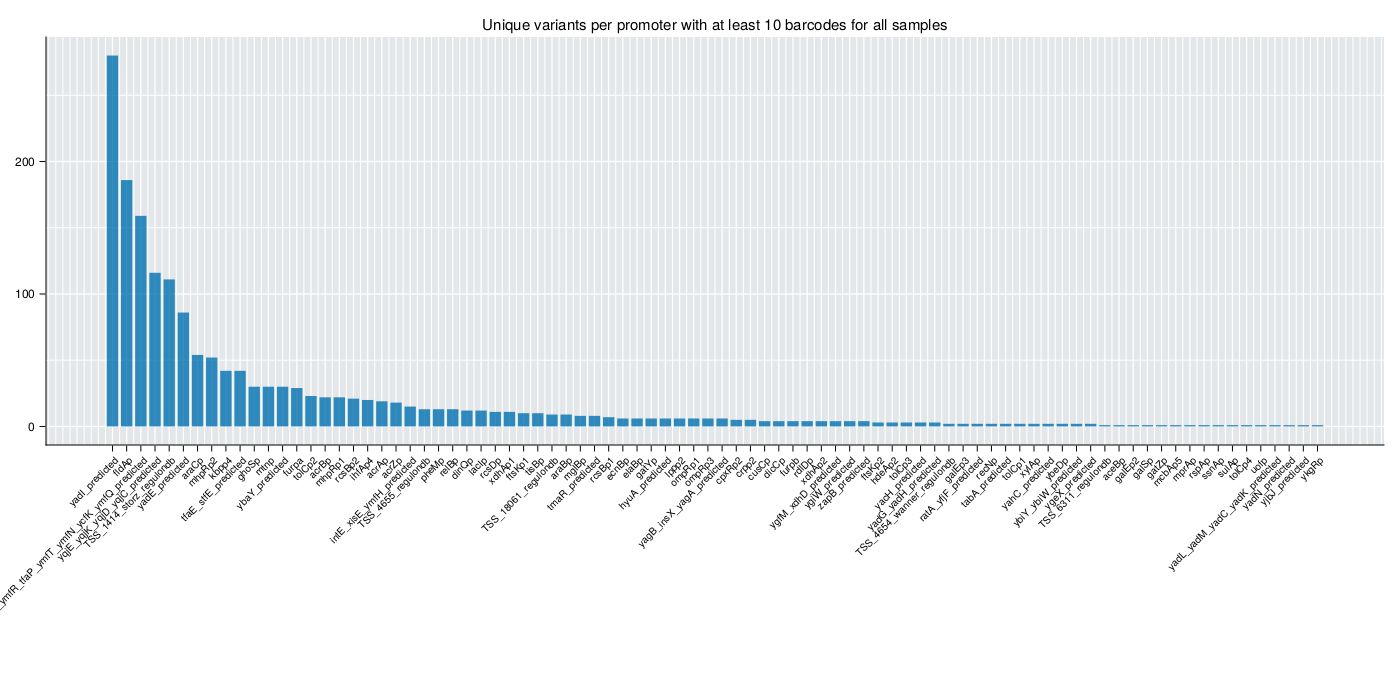

In [11]:
plot_ident_prom_all_samples(df_join, threshold=10)

In [12]:
df_reads = DataFrame()
for (root, dirs, files) in walkdir("../../../data/barcodes/20220514_mapping/100_per_gene_filtered/")
    for file in files
        if split(file, '.')[end] == "txt"
            name = join(split(file, '_')[1:end-2], '_')
            if name != "*"
                _df = CSV.read(
                    joinpath(root, file),
                        DataFrame,
                        types=Dict(
                            "name" => String,
                        )
                    )
                append!(
                    df_reads, 
                    _df
                )
            end
        end
    end
end

In [13]:
df_reads |> names

4-element Vector{String}:
 "promoter"
 "barcode"
 "counts"
 "name"

In [14]:
println("Number of reads in barcode sequencing: $(df.counts |> sum)")
println("Percentage of reads in barcode sequencing compared to mapping run: $(sum(df.counts) / sum(df_mapping.counts))")

Number of reads in barcode sequencing: 19262279
Percentage of reads in barcode sequencing compared to mapping run: 0.06778294788577449


In [15]:
function plot_ident_prom_all_samples(df; threshold=10)
    _df = combine(groupby(df, [:barcode, :promoter, :name]), :counts => sum => :tot_counts)

    df_thresh = _df[_df.tot_counts .> 1, :]
    # function to count unique entries
    num_unique(x) = length(unique(x))
    df_thresh = combine(groupby(df_thresh, [:name, :promoter]), :barcode => length => :uniq_barcodes)
    df_thresh = df_thresh[df_thresh.uniq_barcodes .> threshold, :]
    # Count unique variants per promoter
    df_thresh = combine(groupby(df_thresh, :name), :promoter => num_unique => :uniq_prom)
    return df_thresh.uniq_prom |> sum
end

plot_ident_prom_all_samples (generic function with 1 method)

In [16]:
plot_ident_prom_all_samples(df_join, threshold=1)

125821

In [17]:
plot_ident_prom_all_samples(df_join[df_join.sample .== 1, :], threshold=1)

32243

Play around with the threshold here.

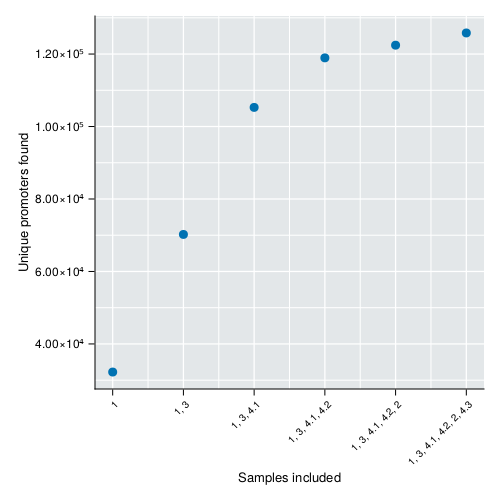

In [18]:
th = 1

x1 = plot_ident_prom_all_samples(
    df_join[
        df_join.sample .== 1, 
        :], 
    threshold=th
    )

x2 = plot_ident_prom_all_samples(
    df_join[
        (df_join.sample .== 1) .|
        (df_join.sample .== 3),
        :], 
        threshold=th
    )

x3 = plot_ident_prom_all_samples(
    df_join[
        (df_join.sample .== 1) .|
        (df_join.sample .== 41) .|
        (df_join.sample .== 3),
        :], 
        threshold=th
    )

x4 = plot_ident_prom_all_samples(
    df_join[
        (df_join.sample .== 1) .|
        (df_join.sample .== 41) .|
        (df_join.sample .== 42) .|
        (df_join.sample .== 3),
        :], 
        threshold=th
    )

x5 = plot_ident_prom_all_samples(
    df_join[
        (df_join.sample .== 1) .|
        (df_join.sample .== 41) .|
        (df_join.sample .== 42) .|
        (df_join.sample .== 2) .|
        (df_join.sample .== 3),
        :], 
        threshold=th
    )

x6 = plot_ident_prom_all_samples(
    df_join[
        (df_join.sample .== 1) .|
        (df_join.sample .== 41) .|
        (df_join.sample .== 42) .|
        (df_join.sample .== 2) .|
        (df_join.sample .== 43) .|
        (df_join.sample .== 3),
        :], 
        threshold=th
    )

fig = Figure(resolution=(500, 500))
ax = Axis(fig[1, 1])
ax.ylabel = "Unique promoters found"
ax.xlabel = "Samples included"
ax.xticks = (
    1:6,
    [
        "1",
        "1, 3",
        "1, 3, 4.1",
        "1, 3, 4.1, 4.2",
        "1, 3, 4.1, 4.2, 2",
        "1, 3, 4.1, 4.2, 2, 4.3"
    ]
)
ax.xticklabelrotation = pi/4
ax.yticklabelsize = 12
scatter!([x1, x2, x3, x4, x5, x6])

save("../../../figures/samples_prom_identified.pdf", fig)

fig